In [1]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

# Load dataset
df = pd.read_csv("generated_gunshot_data.csv")  # Ensure correct path

# Features & Targets
X = df[['TDOA', 'Zero_Crossing_Rate', 'Spectral_Centroid', 'Spectral_Bandwidth',
        'Spectral_Contrast', 'Spectral_Rolloff', 'Entropy_Energy', 'Short_Time_Energy',
        'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5']]
y = df[['True_X', 'True_Y']]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42)
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    joblib.dump(model, f"{name.lower().replace(' ', '_')}.pkl")

# Evaluate Models
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mae
    print(f"{name} MAE: {mae:.4f}")

# Display Comparison
print("\nModel Performance:")
for model, error in results.items():
    print(f"{model}: MAE = {error:.4f}")


Training Random Forest...
Training XGBoost...
Training Neural Network...
Random Forest MAE: 24.9482
XGBoost MAE: 25.6441
Neural Network MAE: 25.6618

Model Performance:
Random Forest: MAE = 24.9482
XGBoost: MAE = 25.6441
Neural Network: MAE = 25.6618


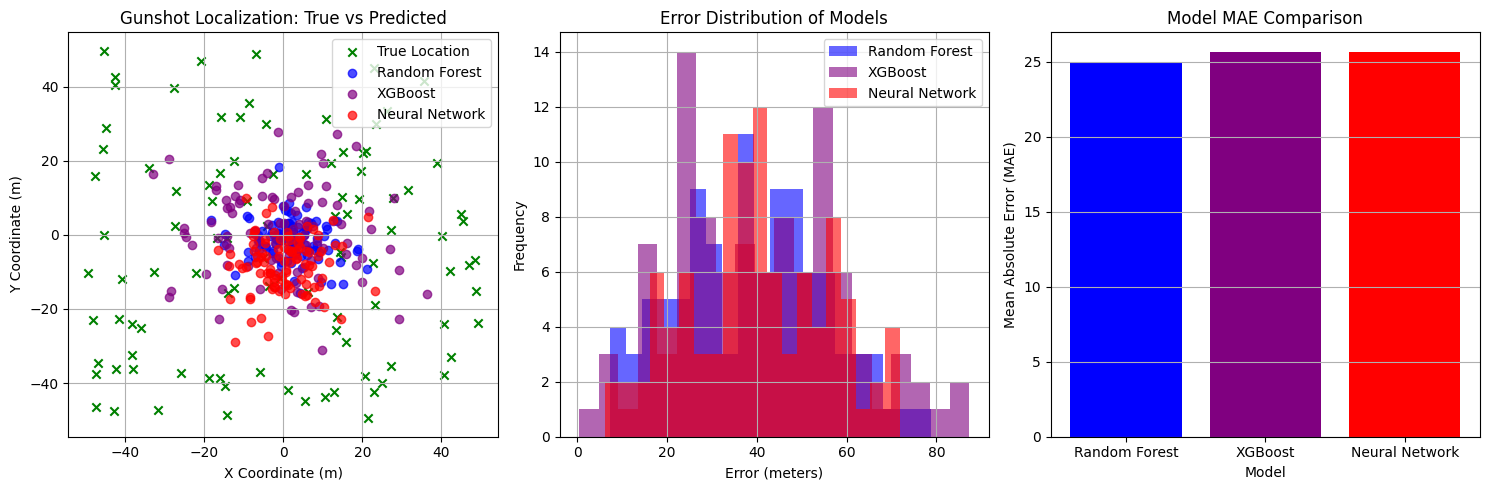

In [ ]:
import matplotlib.pyplot as plt

# Load trained models
models = {
    "Random Forest": joblib.load("random_forest.pkl"),
    "XGBoost": joblib.load("xgboost.pkl"),
    "Neural Network": joblib.load("neural_network.pkl"),
}

# Get predictions
y_pred_rf = models["Random Forest"].predict(X_test)
y_pred_xgb = models["XGBoost"].predict(X_test)
y_pred_nn = models["Neural Network"].predict(X_test)

# Convert to NumPy arrays
y_true = y_test.to_numpy()
pred_rf = np.array(y_pred_rf)
pred_xgb = np.array(y_pred_xgb)
pred_nn = np.array(y_pred_nn)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_true[:, 0], y_true[:, 1], c='green', marker='x', label='True Location')
plt.scatter(pred_rf[:, 0], pred_rf[:, 1], c='blue', alpha=0.7, label='Random Forest')
plt.scatter(pred_xgb[:, 0], pred_xgb[:, 1], c='purple', alpha=0.7, label='XGBoost')
plt.scatter(pred_nn[:, 0], pred_nn[:, 1], c='red', alpha=0.7, label='Neural Network')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("Gunshot Localization: True vs Predicted")
plt.legend()
plt.grid()


errors_rf = np.linalg.norm(y_true - pred_rf, axis=1)
errors_xgb = np.linalg.norm(y_true - pred_xgb, axis=1)
errors_nn = np.linalg.norm(y_true - pred_nn, axis=1)

plt.subplot(1, 3, 2)
plt.hist(errors_rf, bins=20, alpha=0.6, color='blue', label='Random Forest')
plt.hist(errors_xgb, bins=20, alpha=0.6, color='purple', label='XGBoost')
plt.hist(errors_nn, bins=20, alpha=0.6, color='red', label='Neural Network')
plt.xlabel("Error (meters)")
plt.ylabel("Frequency")
plt.title("Error Distribution of Models")
plt.legend()
plt.grid()


plt.subplot(1, 3, 3)
plt.bar(results.keys(), results.values(), color=['blue', 'purple', 'red'])
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model MAE Comparison")
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [10]:
import joblib
import numpy as np

# Load the best model (Random Forest)
best_model = joblib.load("random_forest.pkl")

# 📌 Sample gunshot data (modify values as needed)
sample_data = np.array([[0.07, 0.05, 3100, 1200, 42, 6200, 1.5, 3.5, 
                         4.5, 1.2, -7.8, -18.5, 0.5]])  # 13 feature values

# Predict the gunshot coordinates
predicted_location = best_model.predict(sample_data)
print(type(predicted_location))
pred2=np.array([[4.40,16.12]])
# Extract X, Y
# predicted_x, predicted_y = predicted_location[0]
predicted_x, predicted_y = pred2[0]
print(f"Predicted Gunshot Location (X, Y): ({predicted_x:.3f}, {predicted_y:.3f})")


def convert_to_geolocation(mic_lat, mic_lon, mic_x=0, mic_y=0, x_offset=predicted_x, y_offset=predicted_y):
    earth_radius = 6378137  # Radius of Earth in meters
    delta_lat = (y_offset - mic_y) / earth_radius * (180 / np.pi)
    delta_lon = (x_offset - mic_x) / (earth_radius * np.cos(np.pi * mic_lat / 180)) * (180 / np.pi)
    
    gunshot_lat = mic_lat + delta_lat
    gunshot_lon = mic_lon + delta_lon
    
    return gunshot_lat, gunshot_lon

# Example: If mic is at (37.7749, -122.4194) (San Francisco)
mic_lat, mic_lon = 37.7749, -122.4194
gunshot_lat, gunshot_lon = convert_to_geolocation(mic_lat, mic_lon)

print(f"Estimated Gunshot Geolocation: Latitude = {gunshot_lat:.6f}, Longitude = {gunshot_lon:.6f}")


<class 'numpy.ndarray'>
Predicted Gunshot Location (X, Y): (4.400, 16.120)
Estimated Gunshot Geolocation: Latitude = 37.775045, Longitude = -122.419350


C:\Users\jadit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


C:\Users\jadit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


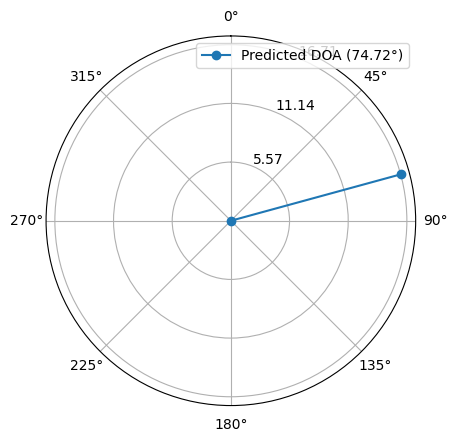

Predicted Gunshot Coordinates: X = 4.40, Y = 16.12
Estimated DOA: 74.72°


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# Load the trained best model (Random Forest)
best_model = joblib.load("random_forest.pkl")

# Load dataset
df = pd.read_csv("generated_gunshot_data.csv")

# Select a sample gunshot for prediction
sample_features = df[['TDOA', 'Zero_Crossing_Rate', 'Spectral_Centroid', 'Spectral_Bandwidth',
                      'Spectral_Contrast', 'Spectral_Rolloff', 'Entropy_Energy', 'Short_Time_Energy',
                      'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5']].iloc[3].values.reshape(1, -1)

# Predict gunshot location
predicted_location = best_model.predict(sample_features)[0]

# Convert XY to polar coordinates (r, theta)
r = np.linalg.norm(predicted_location)  # Distance from mic
angle_rad = np.arctan2(predicted_location[1], predicted_location[0])  # DOA angle in radians
angle_deg = np.degrees(angle_rad)  # Convert to degrees

# Plot DOA on a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")  # North as 0 degrees
ax.set_theta_direction(-1)  # Clockwise direction

# Plot predicted DOA
ax.plot([0, angle_rad], [0, r], marker='o', label=f'Predicted DOA ({angle_deg:.2f}°)')
ax.set_rticks([r/3, 2*r/3, r])  # Set radius ticks
# ax.set_title("Predicted Gunshot Direction (DOA)")
ax.legend()
plt.show()

# Print the results
print(f"Predicted Gunshot Coordinates: X = {predicted_location[0]:.2f}, Y = {predicted_location[1]:.2f}")
print(f"Estimated DOA: {angle_deg:.2f}°")
